# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import cv2
import numpy as np
import os
from imageio import imread 
from skimage.transform import resize 
import datetime
import os
import matplotlib.pyplot as plt
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sys import getsizeof
from keras.layers import LSTM, Bidirectional,Conv2D,MaxPooling2D, GlobalAveragePooling2D
from PIL import Image, ImageFilter, ImageEnhance

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)

In [3]:
# !pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.random.set_seed(30)

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.backend import dropout

**Google Drive** 

To extract Google Drive zip from a Google colab notebook, Please set "google_drivedata" variable as True.

In [5]:
google_drivedata=True

In [6]:
if(google_drivedata):
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)
    !unzip '/content/gdrive/MyDrive/RNNAssignment.zip' -d '/content/gdrive/MyDrive/RNNData'
    !ls '/content/gdrive/MyDrive/RNNData/Project_data/'

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/MyDrive/RNNData/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /content/gdrive/MyDrive/RNNData/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /content/gdrive/MyDrive/RNNData/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /content/gdrive/MyDrive/RNNData/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /content/gdrive/MyDrive/RNNData/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /content/gdrive/MyDrive/RNNData/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: /content/gdrive/MyDrive/RNNData/Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: /conten

In [7]:
if(google_drivedata):
  ## Read from google drive
    file_path= "/content/gdrive/MyDrive/RNNData/Project_data/"
else:
    file_path= "D:/Master of AI/IIITB EPG/Assignments/Gesture Recognition/Project_data/"

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [8]:
train_doc = np.random.permutation(open(file_path+'train.csv').readlines())
val_doc = np.random.permutation(open(file_path+'val.csv').readlines())

batch_size = 40 #experiment with the batch size
total_frames=30
num_classes=5
num_channels=3

In [9]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
## Checking the GPU configuration
!nvidia-smi

Wed Nov 16 10:36:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   27C    P0    49W / 400W |    632MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size,image_height,image_width,frames_to_sample,augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels= one_batch_data(source_path,t,batch,batch_size,img_idx,image_height,image_width,augment)
            yield batch_data, batch_labels 

        remaining_seq=len(t)%batch_size

        # write the code for the remaining data points which are left after full batches
        if (remaining_seq != 0):
            batch_data, batch_labels= one_batch_data(source_path,t,num_batches,batch_size,img_idx,image_height,image_width,augment,remaining_seq)
            yield batch_data, batch_labels 
        
def one_batch_data(source_path,t,batch,batch_size,img_idx,image_height,image_width,augment,remaining_seq=0):
  
    seq_len = remaining_seq if remaining_seq else batch_size
    batch_data = np.zeros((seq_len,len(img_idx),image_height,image_width,num_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((seq_len,num_classes)) # batch_labels is the one hot representation of the output

    if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),image_height,image_width,num_channels))

    for folder in range(seq_len): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            # if smaller image crop at center for 120x120
            if image.shape == 160:
                image =  image[:120, 20:140]
            
            image_resized  = resize(image,(image_height, image_width,3)).astype(np.float32)
            #image.resize(image_height, image_width)
            batch_data[folder,idx,:,:,0]  =image_resized[:,:,0]/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1]  =image_resized[:,:,1]/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2]  =image_resized[:,:,2]/255 #normalise and feed in the image
            
            if (augment):
                shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                    (image.shape[1], image.shape[0]))
                            
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                            
                cropped=shifted[x0:x1,y0:y1,:]
                            
                image_resized=resize(cropped,(image_height, image_width,3)).astype(np.float32)
                batch_data_aug[folder,idx,:,:,0] =(image_resized[:,:,0])/255#= image_resized[:,:,0] - 104 #  
                batch_data_aug[folder,idx,:,:,1] =(image_resized[:,:,1])/255#= image_resized[:,:,1] - 117 #  
                batch_data_aug[folder,idx,:,:,2] =(image_resized[:,:,2])/255#= image_resized[:,:,2] - 123 #  
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  
    if (augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    return(batch_data,batch_labels)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = file_path+'train'
val_path = file_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30



## Plotting


In [13]:
# function to plot the training/Validation accuracies/losses.

def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(h.history['val_categorical_accuracy']))

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
#write your model here
#Base Model

def basemodel(frames_to_sample,image_height,image_width):
    input_shape = (frames_to_sample, image_height, image_width, num_channels)
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32, (2, 2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(64, (2, 2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    optimiser = keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# Train Method

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
#optimiser = keras.optimizers.Adam()
#model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
#train_generator = generator(train_path, train_doc, batch_size)
#val_generator = generator(val_path, val_doc, batch_size)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
def train_model(model, batch_size,num_epochs,image_height,image_width,frames_to_sample, augment_data=False):
    train_generator = generator(train_path, train_doc, batch_size,image_height,image_width,frames_to_sample,augment_data)
    val_generator = generator(val_path, val_doc, batch_size,image_height,image_width,frames_to_sample)
    model_name = 'Gesture_recognition' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
      
    if not os.path.exists(model_name):
        os.mkdir(model_name)
          
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq= 'epoch')
    LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 3, verbose = 1)
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=5,verbose=1)
    callbacks_list = [checkpoint, LR,earlystop]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

  
    history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, 
                      validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  
    return history

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
#model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Expermintation with small epochs and combination of parameters

In [ ]:
frames_to_sample=20
image_height=120
image_width=120
batch_size=30
num_epochs=3

conv_3d1_model=basemodel(frames_to_sample,image_height,image_width)
print("Total Params:", conv_3d1_model.count_params())
train_model(conv_3d1_model,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 900805
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 2.1370 - categorical_accuracy: 0.2911Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-2.13701-0.29110-1.62814-0.19000.h5
23/23 [==============================] - 124s 6s/step - loss: 2.1370 - categorical_accuracy: 0.2911 - val_loss: 1.6281 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.5041 - categorical_accuracy: 0.4736
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-1.50409-0.47360-2.11921-0.17000.h5
23/23 [==============================] - 122s 6s/step - loss: 1.5041 - categorical_accuracy: 0.4736 - val_loss: 2.1192 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/3
23/23 [================

In [ ]:
frames_to_sample=30
image_height=100
image_width=100
batch_size=60
num_epochs=2

#conv_3d2_model=basemodel(frames_to_sample,image_height,image_width)
#print("Total Params:", conv_3d2_model.count_params())
#train_model(conv_3d2_model,batch_size,num_epochs,image_height,image_width,frames_to_sample)

##### Conclusion:

We had hit the limit on memory resources with image resolution of 100X100 with 30 frames and batch_size of 60. GPU restarted automatically on Google Colab.

In [ ]:
frames_to_sample=20
image_height=160
image_width=160
batch_size=30
num_epochs=2

conv_3d1_model=basemodel(frames_to_sample,image_height,image_width)
print("Total Params:", conv_3d1_model.count_params())
train_model(conv_3d1_model,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 1736389
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.9111 - categorical_accuracy: 0.3333Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-1.91109-0.33333-13.37759-0.24000.h5
23/23 [==============================] - 138s 6s/step - loss: 1.9111 - categorical_accuracy: 0.3333 - val_loss: 13.3776 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.4688 - categorical_accuracy: 0.4630
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-1.46878-0.46305-6.21401-0.24000.h5
23/23 [==============================] - 135s 6s/step - loss: 1.4688 - categorical_accuracy: 0.4630 - val_loss: 6.2140 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [ ]:
frames_to_sample=16   
image_height=100
image_width=100
batch_size=20
num_epochs=3

conv_3d3_model=basemodel(frames_to_sample,image_height,image_width)
print("Total Params:", conv_3d3_model.count_params())
train_model(conv_3d3_model,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 687813
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 20
Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 2.0907 - categorical_accuracy: 0.3183Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 20

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-2.09075-0.31825-2.21094-0.21000.h5
34/34 [==============================] - 100s 3s/step - loss: 2.0907 - categorical_accuracy: 0.3183 - val_loss: 2.2109 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.5066 - categorical_accuracy: 0.4525
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-1.50661-0.45249-3.35422-0.24000.h5
34/34 [==============================] - 98s 3s/step - loss: 1.5066 - categorical_accuracy: 0.4525 - val_loss: 3.3542 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/3
34/34 [=================

In [ ]:
frames_to_sample=30
image_height=120
image_width=120
batch_size=40
num_epochs=3

conv_3d1_model=basemodel(frames_to_sample,image_height,image_width)
print("Total Params:", conv_3d1_model.count_params())
train_model(conv_3d1_model,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 900805
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 40
Epoch 1/3
17/17 [==============================] - ETA: 0s - loss: 2.0816 - categorical_accuracy: 0.3167Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 40

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-2.08159-0.31674-1.53681-0.25000.h5
17/17 [==============================] - 187s 12s/step - loss: 2.0816 - categorical_accuracy: 0.3167 - val_loss: 1.5368 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/3
17/17 [==============================] - ETA: 0s - loss: 1.5675 - categorical_accuracy: 0.4570
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-1.56753-0.45701-2.12151-0.14000.h5
17/17 [==============================] - 185s 12s/step - loss: 1.5675 - categorical_accuracy: 0.4570 - val_loss: 2.1215 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/3
17/17 [==============

**Conclusion:**
* As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size.

* So experiment will be done with batch size fixed around 20 - 40 and changing the resolution and number of image per sequence based on the device memory constraints. 


# Model 1 - No Data Augmentation Batch Size 30 and Epoch 10


In [ ]:
def define_model(frames_to_sample,image_height,image_width,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                   input_shape=(frames_to_sample,image_height,image_width,num_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
frames_to_sample=30
image_height=160
image_width=160
batch_size=30
num_epochs=10

conv_3d1_model=define_model(frames_to_sample,image_height,image_width)
conv_3d1_model.summary()

print("Total Params:", conv_3d1_model.count_params())
history_model1 = train_model(conv_3d1_model,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_58 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_41 (Activation)  (None, 15, 80, 80, 32)  

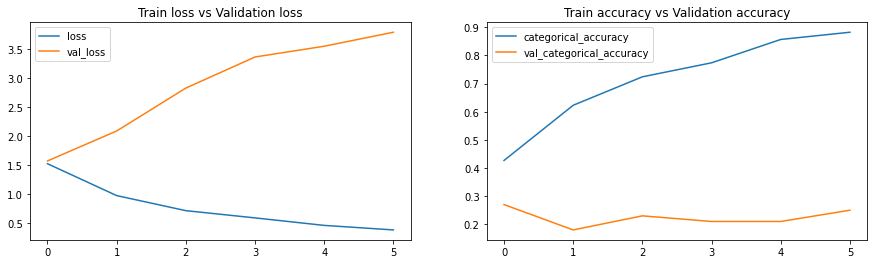

Max. Training Accuracy 0.8823529481887817
Max. Validation Accuracy 0.27000001072883606


In [ ]:
plotModelHistory(history_model1)

**Observation:**
* Model is clearly overfitting here. Lets try with Augmentation.


# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [ ]:
frames_to_sample=30
image_height=160
image_width=160
batch_size=30
num_epochs=10

conv_3d1_model2=define_model(frames_to_sample,image_height,image_width,dense_neurons=256,dropout=0.5)
conv_3d1_model2.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_88 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_61 (Activation)  (None, 15, 80, 80, 32)  

In [ ]:
print("Total Params:", conv_3d1_model2.count_params())
history_model2 = train_model(conv_3d1_model2,batch_size,num_epochs,image_height,image_width,frames_to_sample,augment_data=True)

Total Params: 3638981
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.7769 - categorical_accuracy: 0.4344 Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-1.77687-0.43439-2.09391-0.24000.h5
23/23 [==============================] - 342s 15s/step - loss: 1.7769 - categorical_accuracy: 0.4344 - val_loss: 2.0939 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.3172 - categorical_accuracy: 0.5520 
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-1.31722-0.55204-2.45300-0.32000.h5
23/23 [==============================] - 337s 15s/step - loss: 1.3172 - categorical_accuracy: 0.5520 - val_loss: 2.4530 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/10
23/23 [========

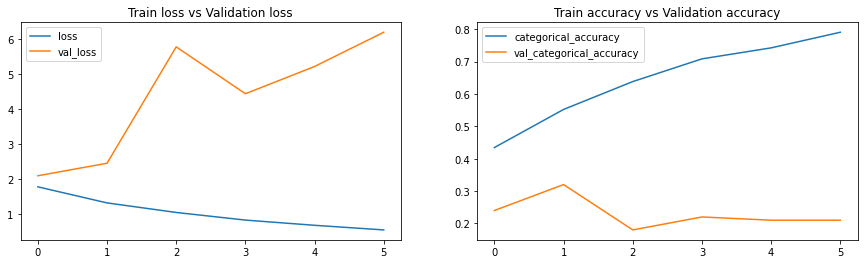

Max. Training Accuracy 0.7903469204902649
Max. Validation Accuracy 0.3199999928474426


In [ ]:
plotModelHistory(history_model2)

**Observation:**

Still not so much success even after augmentation. Lets try reduing filter 
size and image resolution.

# Model 3 & 4 - Reduce filter size to (2,2,2) and image res to 100 x 100

In [ ]:
def define_model2(frames_to_sample,image_height,image_width,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                   input_shape=(frames_to_sample,image_height,image_width,num_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam(lr=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
frames_to_sample=20
image_height=100
image_width=100
batch_size=30
num_epochs=15

conv_3d_model3=define_model2(frames_to_sample,image_height,image_width,filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d_model3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 20, 100, 100, 16)  400       
                                                                 
 activation_64 (Activation)  (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization_94 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 10, 50, 50, 16)    0         
                                                                 
 conv3d_65 (Conv3D)          (None, 10, 50, 50, 32)  

In [ ]:
print("Total Params:", conv_3d_model3.count_params())
history_model3 = train_model(conv_3d_model3,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 1336629
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6112 - categorical_accuracy: 0.3997Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-1.61115-0.39970-1.93888-0.16000.h5
23/23 [==============================] - 124s 6s/step - loss: 1.6112 - categorical_accuracy: 0.3997 - val_loss: 1.9389 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.1099 - categorical_accuracy: 0.5988
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-1.10994-0.59879-2.83601-0.14000.h5
23/23 [==============================] - 125s 6s/step - loss: 1.1099 - categorical_accuracy: 0.5988 - val_loss: 2.8360 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/15
23/23 [====

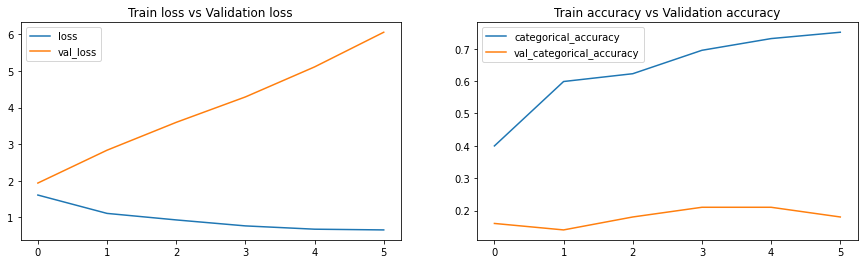

Max. Training Accuracy 0.7511312365531921
Max. Validation Accuracy 0.20999999344348907


In [ ]:
plotModelHistory(history_model3)

**Model 4**

Added dropout, increase and reduced filter size.

In [ ]:
frames_to_sample=30
image_height=100
image_width=100
batch_size=30
num_epochs=15

conv_3d_model4=define_model2(frames_to_sample,image_height,image_width,filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d_model4.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 30, 100, 100, 16)  400       
                                                                 
 activation_68 (Activation)  (None, 30, 100, 100, 16)  0         
                                                                 
 batch_normalization_100 (Ba  (None, 30, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 15, 50, 50, 16)    0         
                                                                 
 conv3d_69 (Conv3D)          (None, 15, 50, 50, 32)  

In [ ]:
print("Total Params:", conv_3d_model4.count_params())
history_model4 = train_model(conv_3d_model4,batch_size,num_epochs,image_height,image_width,frames_to_sample,augment_data=False)

Total Params: 1336629
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.4744 - categorical_accuracy: 0.4344Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-1.47439-0.43439-2.06724-0.16000.h5
23/23 [==============================] - 185s 8s/step - loss: 1.4744 - categorical_accuracy: 0.4344 - val_loss: 2.0672 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 0.8737 - categorical_accuracy: 0.6546
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-0.87373-0.65460-3.30982-0.16000.h5
23/23 [==============================] - 183s 8s/step - loss: 0.8737 - categorical_accuracy: 0.6546 - val_loss: 3.3098 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/15
23/23 [====

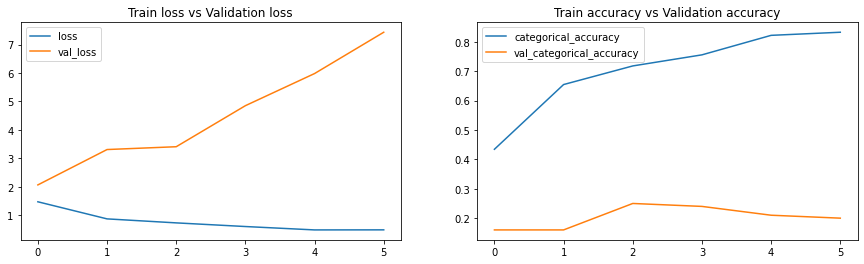

Max. Training Accuracy 0.8325791954994202
Max. Validation Accuracy 0.25


In [ ]:
plotModelHistory(history_model4)

##### Conclusion

No success with overfitting. Lets switch to TimeDistributed Conv2D + GRU

# Model 5 - TimeDistributed Conv2D + GRU

In [54]:
def define_modeltGRU(frames_to_sample,image_height,image_width,dropout=0):
    input_shape = (frames_to_sample, image_height, image_width, num_channels)

    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed( MaxPooling2D((2,2))) )
    model.add(BatchNormalization())

    model.add(TimeDistributed( Conv2D(64, (3,3), activation='relu')) )
    model.add(TimeDistributed( MaxPooling2D((2,2))) )
    model.add(BatchNormalization())

    model.add(TimeDistributed( Conv2D(128, (3,3), activation='relu')) )
    model.add(TimeDistributed( MaxPooling2D((2,2))) )
    model.add(BatchNormalization())

    model.add(TimeDistributed( Conv2D(256, (3,3), activation='relu')) )
    model.add(TimeDistributed( MaxPooling2D((2,2))) )
    model.add(BatchNormalization())

    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(BatchNormalization())
    if(dropout>0):
        model.add(Dropout(dropout))

    model.add(GRU(128))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    if(dropout>0):
        model.add(Dropout(dropout))
  
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model 

In [55]:
frames_to_sample=30
image_height=160
image_width=160
batch_size=30
num_epochs=10

conv_3d_GRUmodel=define_modeltGRU(frames_to_sample,image_height,image_width)
conv_3d_GRUmodel.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_140 (TimeD  (None, 30, 158, 158, 32)  896      
 istributed)                                                     
                                                                 
 time_distributed_141 (TimeD  (None, 30, 79, 79, 32)   0         
 istributed)                                                     
                                                                 
 batch_normalization_49 (Bat  (None, 30, 79, 79, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_142 (TimeD  (None, 30, 77, 77, 64)   18496     
 istributed)                                                     
                                                                 
 time_distributed_143 (TimeD  (None, 30, 38, 38, 64) 

In [56]:
print("Total Params:", conv_3d_GRUmodel.count_params())
history_modelGRU = train_model(conv_3d_GRUmodel,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 482693
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.2199 - categorical_accuracy: 0.4962Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1610_36_25.364274/model-00001-1.21988-0.49623-1.61288-0.21000.h5
23/23 [==============================] - 206s 9s/step - loss: 1.2199 - categorical_accuracy: 0.4962 - val_loss: 1.6129 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.9578 - categorical_accuracy: 0.6139
Epoch 2: saving model to Gesture_recognition_2022-11-1610_36_25.364274/model-00002-0.95779-0.61388-1.63396-0.24000.h5
23/23 [==============================] - 201s 9s/step - loss: 0.9578 - categorical_accuracy: 0.6139 - val_loss: 1.6340 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/10
23/23 [=============

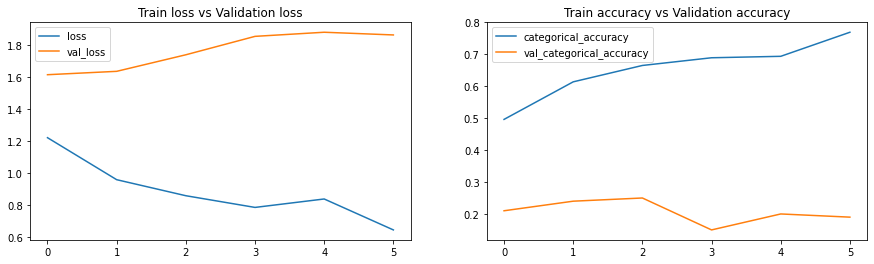

Max. Training Accuracy 0.7692307829856873
Max. Validation Accuracy 0.25


In [57]:
plotModelHistory(history_modelGRU)

# Model 6 - TimeDistributed Conv2D + GRU with dropout

In [40]:
frames_to_sample=25
image_height=120
image_width=120
batch_size=30
num_epochs=10

conv_3d_GRUmodel2=define_modeltGRU(frames_to_sample,image_height,image_width,dropout=0.5)
print("Total Params:", conv_3d_GRUmodel2.count_params())
history_modelGRU2 = train_model(conv_3d_GRUmodel2,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 482693
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.2021Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1610_36_25.364274/model-00001-nan-0.20211-nan-0.18000.h5
23/23 [==============================] - 159s 7s/step - loss: nan - categorical_accuracy: 0.2021 - val_loss: nan - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.2051
Epoch 2: saving model to Gesture_recognition_2022-11-1610_36_25.364274/model-00002-nan-0.20513-nan-0.18000.h5
23/23 [==============================] - 154s 7s/step - loss: nan - categorical_accuracy: 0.2051 - val_loss: nan - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/10
23/23 [==============================] - ETA: 0s - los

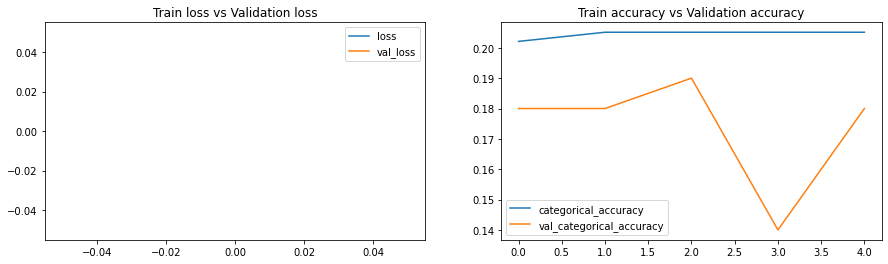

Max. Training Accuracy 0.20512820780277252
Max. Validation Accuracy 0.1899999976158142


In [41]:
plotModelHistory(history_modelGRU2)

# CNN- LSTM Model 7

In [59]:

def define_model7(frames_to_sample,image_height,image_width):
    Input_shape_1 = (frames_to_sample, image_height, image_width, num_channels)
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
    model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
    model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
    model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.5))

    model.add(LSTM(512, return_sequences=False, dropout=0.5))
    model.add(Dense(num_classes, activation='softmax'))
  
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model 


In [60]:
frames_to_sample=30
image_height=120
image_width=120
batch_size=30
num_epochs=20

conv_3d_model7=define_model7(frames_to_sample,image_height,image_width)
conv_3d_model7.summary()

print("Total Params:", conv_3d_model7.count_params())
history_model7 = train_model(conv_3d_model7,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_150 (TimeD  (None, 30, 60, 60, 32)   4736      
 istributed)                                                     
                                                                 
 time_distributed_151 (TimeD  (None, 30, 58, 58, 32)   9248      
 istributed)                                                     
                                                                 
 time_distributed_152 (TimeD  (None, 30, 29, 29, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_153 (TimeD  (None, 30, 29, 29, 64)   18496     
 istributed)                                                     
                                                                 
 time_distributed_154 (TimeD  (None, 30, 29, 29, 64) 

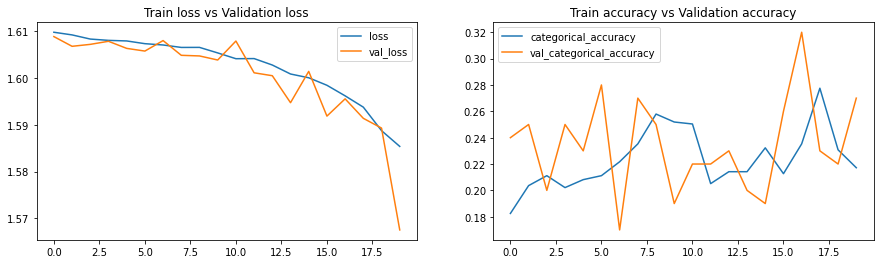

Max. Training Accuracy 0.2775264084339142
Max. Validation Accuracy 0.3199999928474426


In [61]:
plotModelHistory(history_model7)

# Model 8 - CNN & LSTM 

In [62]:
def define_model8(frames_to_sample,image_height,image_width,lstm_cells=64,dense_neurons=64,dropout=0.25):
    model = Sequential()
    Input_shape_1 = (frames_to_sample, image_height, image_width, num_channels)

    model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
    model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
          
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
          
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
          
    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))
          
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))
          
    model.add(Dense(num_classes, activation='softmax'))
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
frames_to_sample=30
image_height=100
image_width=100
batch_size=30
num_epochs=30

conv_3d_model8=define_model8(frames_to_sample,image_height,image_width,lstm_cells=128,dense_neurons=128,dropout=0.5)
conv_3d_model8.summary()

print("Total Params:", conv_3d_model8.count_params())
history_model8 = train_model(conv_3d_model8,batch_size,num_epochs,image_height,image_width,frames_to_sample,augment_data=True)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_178 (TimeD  (None, 30, 50, 50, 32)   4736      
 istributed)                                                     
                                                                 
 time_distributed_179 (TimeD  (None, 30, 48, 48, 32)   9248      
 istributed)                                                     
                                                                 
 time_distributed_180 (TimeD  (None, 30, 24, 24, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_181 (TimeD  (None, 30, 24, 24, 32)   9248      
 istributed)                                                     
                                                                 
 time_distributed_182 (TimeD  (None, 30, 12, 12, 32) 

In [ ]:
plotModelHistory(history_model8)

In [ ]:
frames_to_sample=30
image_height=160
image_width=160
batch_size=30
num_epochs=15

conv_3d_model8_1=define_model8(frames_to_sample,image_height,image_width,lstm_cells=128,dense_neurons=128,dropout=0.5)
#conv_3d_model8_1.summary()

print("Total Params:", conv_3d_model8_1.count_params())
history_model8_1 = train_model(conv_3d_model8_1,batch_size,num_epochs,image_height,image_width,frames_to_sample)

In [ ]:
plotModelHistory(history_model8_1)

# Model 9 - CNN LSTM with GRU



In [ ]:
def define_modelGRU_LSTM(frames_to_sample,image_height,image_width,lstm_cells=64,dense_neurons=64,dropout=0.25):
    input_shape = (frames_to_sample, image_height, image_width, num_channels)
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(lstm_cells))
    model.add(Dropout(dropout))
  
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))
  
    model.add(Dense(num_classes, activation='softmax'))
  
    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    #optimiser = optimizers.Adam(lr=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
frames_to_sample=25
image_height=100
image_width=100
batch_size=30
num_epochs=10

conv_3d_GRUmodel3=define_modelGRU_LSTM(frames_to_sample,image_height,image_width,dropout=0.5)
print("Total Params:", conv_3d_GRUmodel3.count_params())
history_modelGRU3 = train_model(conv_3d_GRUmodel3,batch_size,num_epochs,image_height,image_width,frames_to_sample)

Total Params: 1000293
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 2.0037 - categorical_accuracy: 0.2474Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30

Epoch 1: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00001-2.00374-0.24736-1.61654-0.20000.h5
23/23 [==============================] - 158s 7s/step - loss: 2.0037 - categorical_accuracy: 0.2474 - val_loss: 1.6165 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.6431 - categorical_accuracy: 0.3228
Epoch 2: saving model to Gesture_recognition_2022-11-1602_00_24.406249/model-00002-1.64309-0.32278-1.65253-0.24000.h5
23/23 [==============================] - 153s 7s/step - loss: 1.6431 - categorical_accuracy: 0.3228 - val_loss: 1.6525 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/10
23/23 [============

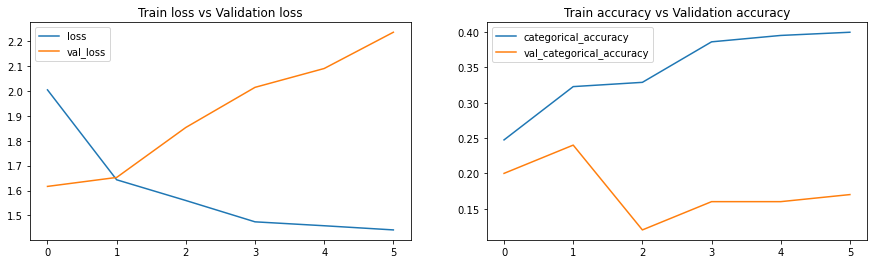

Max. Training Accuracy 0.3996983468532562
Max. Validation Accuracy 0.23999999463558197


In [ ]:
plotModelHistory(history_modelGRU3)

# Transfer Learning with GRU and training all weights

In [19]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

def define_model10(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,num_channels)))
 
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))
          
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))
          
    model.add(Dense(num_classes, activation='softmax'))
          
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

17225924/17225924 [==============================] - 1s 0us/step


In [20]:
class self:
    frames_to_sample=30
    image_height=100
    image_width=100
    batch_size=40

num_epochs=20

conv_3d_model10=define_model10(self,gru_cells=128,dense_neurons=128,dropout=0.25)
#conv_3d_model10.summary()

print("Total Params:", conv_3d_model10.count_params())
history_model10 = train_model(conv_3d_model10,self.batch_size,num_epochs,self.image_height,self.image_width,self.frames_to_sample)

Total Params: 3693253
Source path =  /content/gdrive/MyDrive/RNNData/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.0681 - categorical_accuracy: 0.5913Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 40

Epoch 1: saving model to Gesture_recognition_2022-11-1610_36_25.364274/model-00001-1.06809-0.59125-0.86430-0.71000.h5
17/17 [==============================] - 201s 12s/step - loss: 1.0681 - categorical_accuracy: 0.5913 - val_loss: 0.8643 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.2137 - categorical_accuracy: 0.9382
Epoch 2: saving model to Gesture_recognition_2022-11-1610_36_25.364274/model-00002-0.21373-0.93816-0.57577-0.77000.h5
17/17 [==============================] - 190s 12s/step - loss: 0.2137 - categorical_accuracy: 0.9382 - val_loss: 0.5758 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 3/20
17/17 [==========

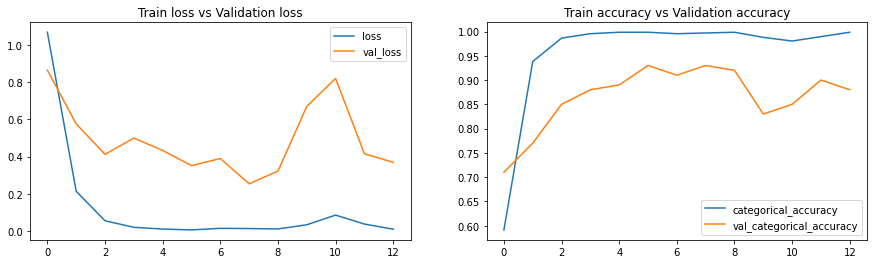

Max. Training Accuracy 0.9984917044639587
Max. Validation Accuracy 0.9300000071525574


In [21]:
plotModelHistory(history_model10)

# Conclusion:

After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
Reason:

- (Training Accuracy : 81%, Validation Accuracy : 62%)

- Number of Parameters(625,029)less according to other models performance

- Learning rate gradually decreacing after some Epoch

The best weights of CNN-LSTM: Gesture_recognition_2022-11-1514_27_07.687069/model-00020-0.70228-0.70588-0.94764-0.59000.h5 (7.25 MB). we considered this weight for model testing, Let's have look at the performance below

# Load and Test best model

In [22]:
import time
from keras.models import load_model
model = load_model('Gesture_recognition_2022-11-1514_27_07.687069/model-00020-0.70228-0.70588-0.94764-0.59000.h5')
#Gesture_recognition_2022-11-1610_36_25.364274/model-00011-0.08571-0.98039-0.81974-0.85000.h5
#model = load_model('Gesture_recognition_2022-11-1610_36_25.364274/model-00008-0.01341-0.99698-0.25390-0.93000.h5') # Transfer Learning

In [23]:
frames_to_sample=30
image_height=100
image_width=100
batch_size=30
num_epochs=30

g=generator(val_path,val_doc,batch_size,image_height,image_width,frames_to_sample,augment=False)
batch_data, batch_labels=next(g)

Source path =  /content/gdrive/MyDrive/RNNData/Project_data/val ; batch size = 30


In [24]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 1s 575ms/step
[2 4 2 1 2 0 3 3 1 3 0 4 3 4 0 3 4 1 4 2 4 3 2 2 1 0 2 4 2 1]


In [25]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])